In [81]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, OrderedDict
import matplotlib
from matplotlib.gridspec import GridSpec
import sys
import random
import copy

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'serif', 'size':12}
plt.rc('font', **font)
plt.rc("lines", linewidth=3.0)
plt.rcParams["savefig.dpi"] = 500
cmap = plt.get_cmap('plasma_r')

savedir = './figs/rf-numeric/'
datadir = './data/'

# Plotting

## Test error curves : figures 4 and 11

In [ ]:
def plot_perfs(runs, title, save=False):
    
    plt.figure(figsize=(5,3))
    for i,run in enumerate(runs):
        args=run['args']
        if not continuous: label = args['actname']
        else: label = '{0:.1f}'.format(args['actname'])
        plt.plot(args['Psi2_list'], run['te_errors'], label=label, color=cmap(i/(len(runs)-1)))
    plt.xscale('log')
    plt.yscale('log')
    plt.axvline(x=1,    color='grey', label='N=D')
    plt.axvline(x=args['Psi1'], color='grey', label='N=P', ls='--')
    plt.xlabel('N/D'      , fontsize=15)
    plt.ylabel('Test loss', fontsize=15)
    plt.legend(bbox_to_anchor=(1.05,1))

    plt.tight_layout()
    if save: plt.savefig(title, bbox_inches='tight')
    plt.show()
    
for continuous in [True, False]:
    for dataset in ['random','MNIST']:
        if continuous:
            runs = torch.load(datadir+'runs_{}_r.pyT'.format(dataset))
            title = savedir+'perfs_%s_r.pdf'%(dataset)
        else:
            runs = torch.load(datadir+'runs_{}.pyT'.format(dataset))
            title = savedir+'perfs_%s.pdf'%(dataset)
        plot_perfs(runs, title = title, save=True)

## Spectra : figures 7 and 14

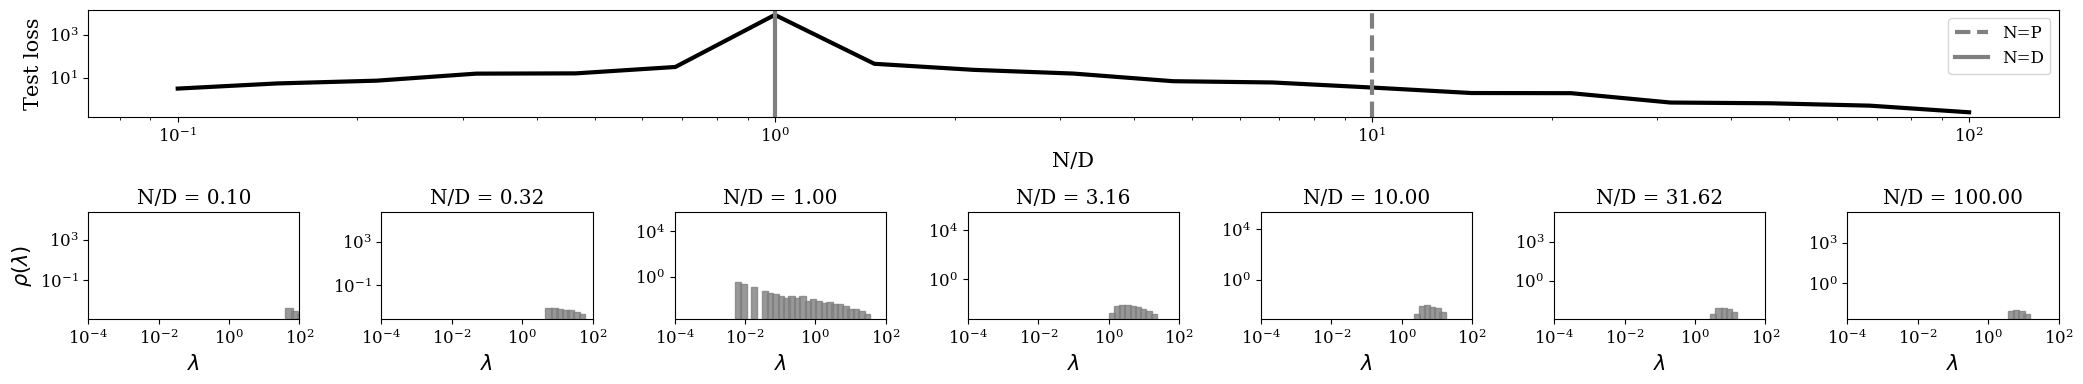

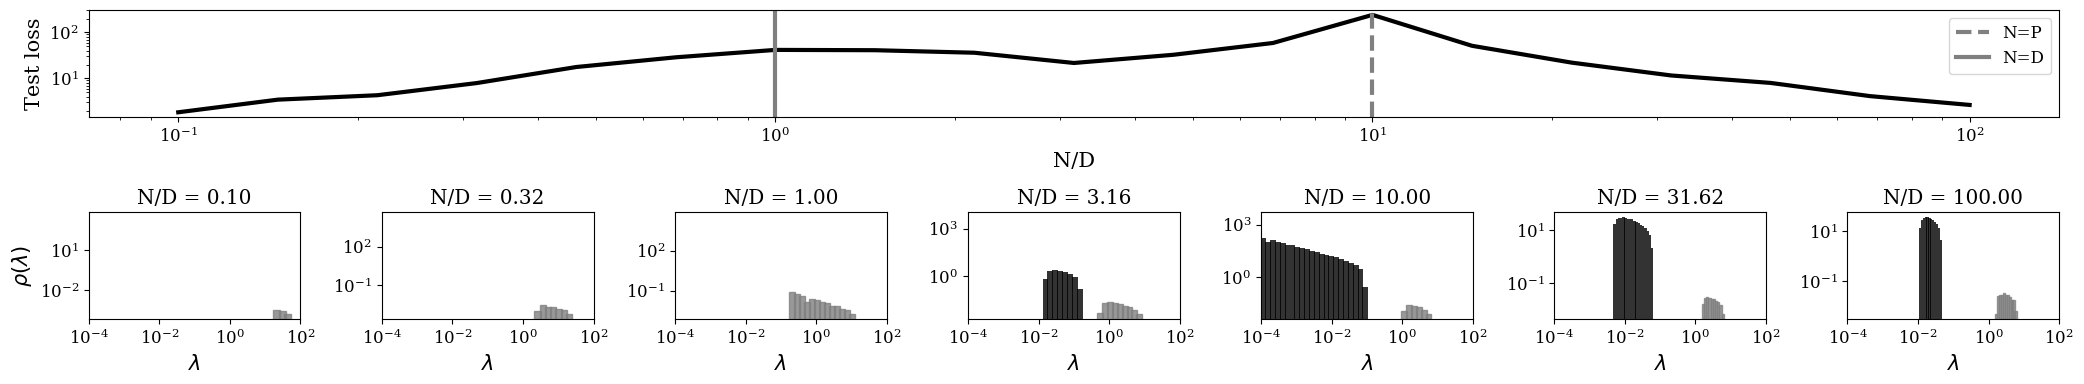

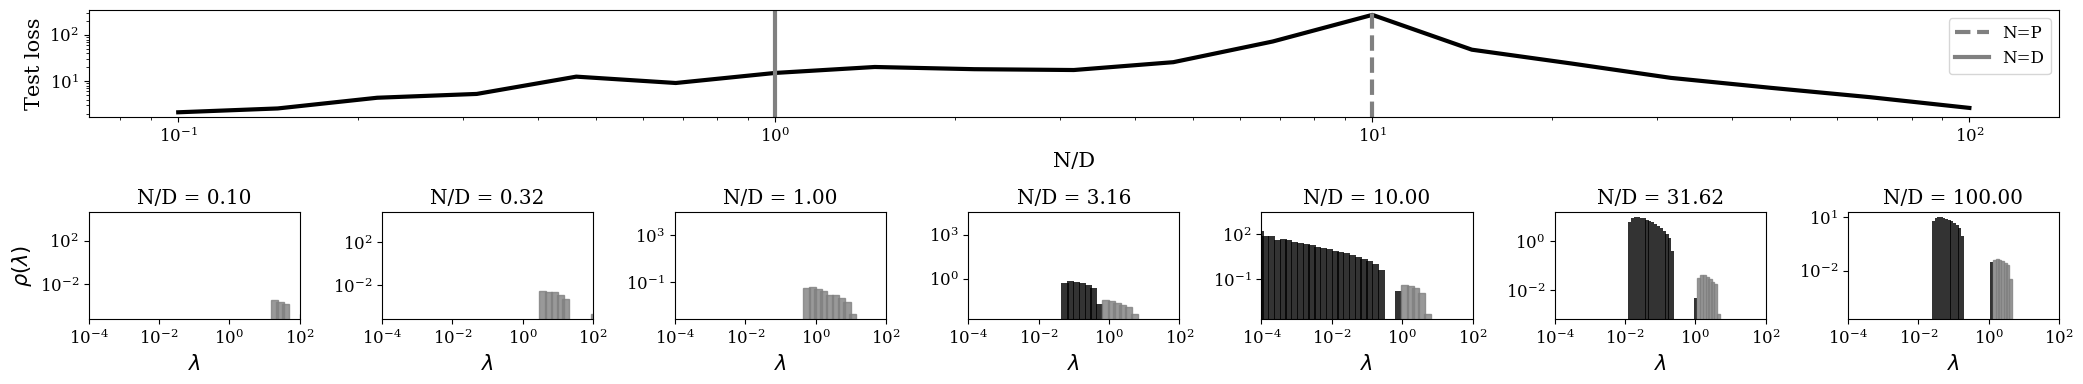

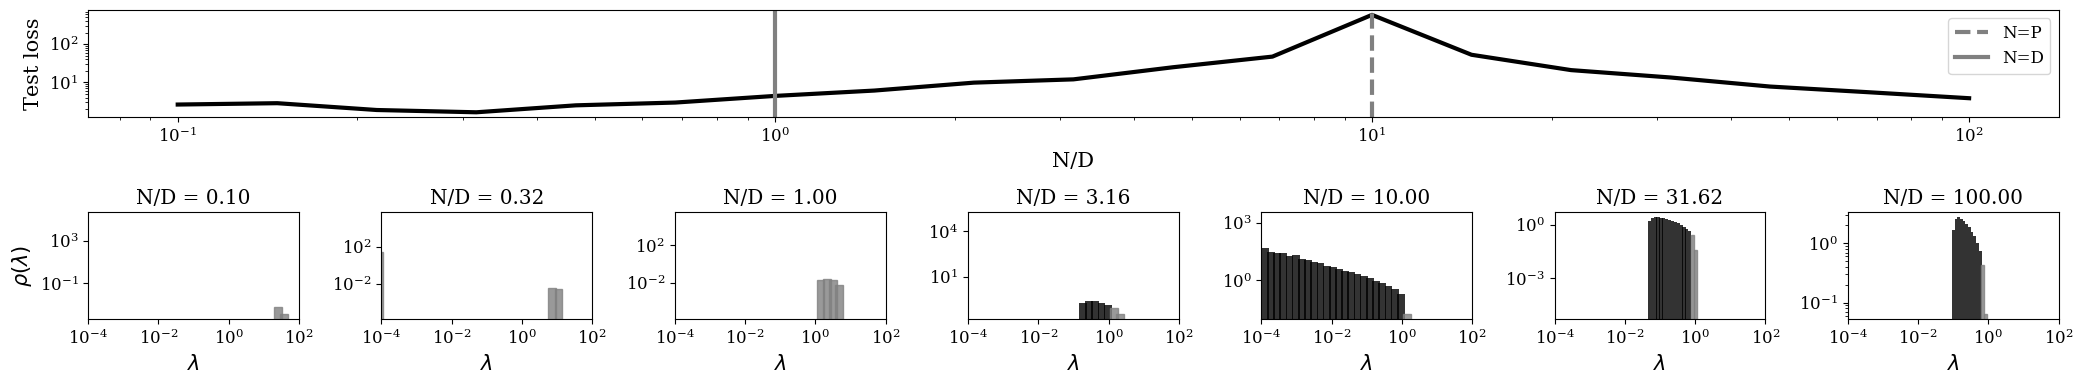

In [93]:
def plot_spectra(run, analytic=False):

    n_spectra = len(run['spectra'].keys())

    fig = plt.figure(1,figsize=(3*n_spectra,4))
    gs = GridSpec(2, n_spectra, figure=fig)

    args=run['args']

    for i, (Psi2, spectrum) in enumerate(run['spectra'].items()):
        
        plt.subplot(gs[1,i])
        bins, patches = plot_loghist(spectrum[:], color='black', alpha=.8, bins=50)
        for b, p in zip(bins,patches):
            if b>spectrum[-args['D']-1]:
                p.set_color('grey')
                pass
        plt.xlim(left=1e-4,right=100)
        plt.xlabel(r'$\lambda$',fontsize=15)
        if i==0: plt.ylabel(r'$\rho(\lambda)$',fontsize=15)
        plt.title('N/D = {0:.2f}'.format(Psi2))
        
        if analytic:
            spectrum = torch.load(datadir+'spectra.pyT')['0.923077'][1/Psi2]
            lam = 10**spectrum[:,0]
            D = args['D']
            P, N = args['Psi1']*D, Psi2*D
            density = spectrum[:,1] 
            plt.loglog(lam, density, color='red', label='analytical')
            plt.xlim(left=1e-3, right=1e2)
            plt.ylim(bottom=1e-4, top=2*max(density))
            if i==0:
                plt.plot([],[],color='black', label='P-D smallest')
                plt.plot([],[],color='grey', label='D largest')
                plt.legend(loc=('upper left'))

    plt.subplot(gs[0,:])
    plt.plot(args['Psi2_list'], run['te_errors'    ], color='k')
    #plt.plot(args['Psi2_list'], run['te_errors_ens'], label='Ensembled error')
    plt.xscale('log')
    plt.yscale('log')
    plt.axvline(x=args['Psi1'], color='grey', ls='--', label='N=P')
    plt.axvline(x=1, color='grey',  label='N=D')
    plt.xlabel('N/D',fontsize=15)
    plt.ylabel('Test loss',fontsize=15)
    plt.legend()

    plt.tight_layout()
    if analytic:
        plt.savefig(savedir+'spectra_num_ana.pdf')
    else:
        plt.savefig(savedir+'spectra_%s_%s.pdf'%(args['dataset'],args['actname']))
    plt.show()
    
for analytic in [True, False]:
    if analytic:
        runs =  torch.load(datadir+'runs_analytic.pyT')
        plot_spectra(runs[0], analytic = True)
    else:    
        for dataset in ['MNIST','random']:
            runs = torch.load(datadir+'runs_{}.pyT'.format(dataset))
            for run in runs:
                plot_spectra(run, analytic = False)

# Runs

In [5]:
def plot_loghist(x, bins, **kwargs):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    widths = (logbins[1:] - logbins[:-1])
    
    hist = np.histogram(x, bins=logbins)
    # %alize by bin width
    hist_norm = hist[0]/widths/len(x)
    barlist = plt.bar(logbins[:-1], hist_norm, widths, **kwargs)
    plt.xscale('log')
    plt.yscale('log')
    return logbins, barlist

def generate_orthogonal(D, P, eps=1, max_iter=100):
    from scipy.stats import ortho_group
    U = torch.from_numpy(ortho_group.rvs(P)).float()
    V = torch.from_numpy(ortho_group.rvs(D)).float()
    S = torch.zeros((P, D))
    for i in range(min(D,P)):
        S[i,i] = D**0.5 * max(1, (D/P)**0.5)
    points = U @ S @ V
    return points

def generate_rfs(K,D,P,init='gaussian'):
    rfs = []
    for k in range(K):
        if init=='gaussian':
            rf = torch.randn((D,P))
        elif init=='orthogonal':
            rf = generate_orthogonal(D, P).t()
        elif init=='even':
            rf = generate_even(D, P, lr=10, eps=.0, max_iter=10).t()
        rfs.append(rf)
    rf = torch.stack(rfs)
    return rf

def normalize(x):
    mean = x.mean(dim=0, keepdim=True)
    std = x.std(dim=0, keepdim=True)
    std[std==0]=1
    return (x-mean)/std

def get_dataset(dataset, D, N_train=10000, N_test=10000, norm=1, resize_method='downsample', cov=None):
    
    if dataset=='random':
        if cov is None:
            tr_data = torch.randn((N_train,D))
            te_data = torch.randn((N_test,D))
        else:
            tr_data = torch.from_numpy(np.random.multivariate_normal(mean=np.zeros(D),cov=cov,size=(N_train))).float()
            te_data = torch.from_numpy(np.random.multivariate_normal(mean=np.zeros(D),cov=cov,size=(N_test ))).float()

    else:
        if resize_method=='downsample': # assumes D is a perfect square
            assert D**0.5==int(D**0.5)
            transforms = torchvision.transforms.Compose([                                                                                                                      
                        torchvision.transforms.Resize(int(D**0.5)), 
                        torchvision.transforms.ToTensor()]) 
            tr_dataset = torchvision.datasets.MNIST('~/data', train=True, download=True, transform=transforms)
            te_dataset = torchvision.datasets.MNIST('~/data', train=False, download=True, transform=transforms)
            tr_data = normalize(torch.cat([tr_dataset[mu][0] for mu in range(N_train)]).view(N_train,D))
            te_data = normalize(torch.cat([te_dataset[mu][0] for mu in range(N_train)]).view(N_train,D))        
        elif resize_method=='PCA':
            tr_dataset = eval('Fast'+dataset.upper())('~/data', train=True, download=True )
            te_dataset = eval('Fast'+dataset.upper())('~/data', train=False, download=True)
            tr_dataset, te_dataset = get_pca(tr_dataset, te_dataset, D, normalized = True)
            tr_data, te_data = tr_dataset.data, te_dataset.data
        else:
            raise NotImplemented
    
    tr_data = tr_data*norm/tr_data.norm(dim=-1,keepdim=True)
    te_data = te_data*norm/te_data.norm(dim=-1,keepdim=True)    
            
    te_data = te_data[:N_test]
    
    return tr_data, te_data
    
def get_act(actname):
    if actname=='relu':
        return lambda x : F.relu(x)
    elif actname=='abs':
        return lambda x : abs(x)
    elif actname=='tanh':
        return lambda x : torch.tanh(x)
    elif actname=='linear':
        return lambda x : x
    elif type(actname)!=str: 
        alpha=actname
        return lambda x : (F.relu(x) + alpha*F.relu(-x) - (1+alpha)/np.sqrt(2*np.pi))/np.sqrt((1+alpha**2)/2 - (1+alpha)**2/(2*np.pi))
    else:
        raise NotImplemented
        
def get_teacher(args):
    beta = torch.randn(args['D'])
    if args['teacher']=='linear':
        return lambda X : X @ beta / args['D']**0.5  
    elif args['teacher']=='sin':
        return lambda X : np.sin(X @ beta / args['D']**0.5)
    else:
        raise NotImplemented
        
def test(k, act, rf, a, te_data, y_test):
            
    K,D,P=rf.size()

    te_errors = []
    for ik in range(int(K/k)):
        y_pred = torch.einsum('knp,kp->kn',(act(te_data @ rf[k*ik:k*(ik+1)] / D**0.5) / D**0.5, a[k*ik:k*(ik+1)]))
        te_error = (y_pred-y_test).mean(0).pow(2).mean()
        te_errors.append(te_error.item())
    return np.mean(te_errors), np.std(te_errors)   

def calc_norms(rf, a, X):
    K, D, P = rf.size()
    N, D = X.size()
    norms_curr = []
    for k in range(K):
        original = a[k]
        norm = original.norm().mean().item()/P
        subspace = X @ rf[k] / D
        subspace = subspace / subspace.norm(dim=-1, keepdim=True)
        projected = original @ subspace.t() @ torch.pinverse(subspace @ subspace.t()) @ subspace / max(1, N/P)
        orth = original-projected
        norm         = original .norm().item()/P
        norm_proj    = projected.norm().item()/P
        norm_orth    = orth     .norm().item()/P
        norms_curr.append([norm, norm_proj, norm_orth])
    norms = np.mean(np.array(norms_curr), axis=0)
    return norms

In [8]:
def run_rf(args):
    
    D = args['D']
    K = args['K']
    Psi1 = args['Psi1']
    P = int(D * Psi1)
    
    tr_data, te_data = get_dataset(args['dataset'], D, N_train=int(D*max(args['Psi2_list'])), N_test=args['N_test'], norm=D**0.5)
    act = get_act(args['actname'])

    te_errors = []
    te_errors_ens = []
    tr_errors = []
    spectra = {}
    modulo = len(args['Psi2_list'])//args['n_spectra']
    
    teacher = get_teacher(args)
        
    y_test = teacher(te_data)
    rf = generate_rfs(K,D,P,init='gaussian')
        
    for i, Psi2 in enumerate(args['Psi2_list']):

        N = int(D * Psi2)
        
        X = tr_data[:N]
        y = teacher(X) + args['tau'] * torch.randn((N,))
        
        a = torch.empty((K,P))

        for k in range(K):
            Z = act(X @ rf[k] / D**0.5) / D**0.5
            a[k] = y @ Z @ torch.from_numpy(np.linalg.pinv((Z.t() @ Z + Psi1 * Psi2 * args['lam'] * torch.eye(P)).numpy()))

        if i%modulo==0:
            cov = Z.T@Z * D / N 
            spectrum = F.relu(torch.symeig(cov)[0]-1e-6) + 1e-6
            spectra[Psi2]=spectrum
        tr_error, tr_error_std     = test(1, act, rf, a, X, y)
        te_error, te_error_std     = test(1, act, rf, a, te_data, y_test)
        te_error_ens, te_error_std = test(K, act, rf, a, te_data, y_test)
        
        tr_errors.append(tr_error)
        te_errors.append(te_error)
        te_errors_ens.append(te_error_ens)
        
    run = {'args':copy.deepcopy(args),
           'tr_errors':tr_errors,
           'te_errors':te_errors,'te_errors_ens':te_errors_ens,
           'spectra':spectra}
    return run


In [80]:
args = {'D' :100,
    'dataset':'random',
    'teacher':'linear',
    'actname':'relu',
    'Psi1'  : 10,
    'Psi2_list' : np.logspace(-1,2,19),
    'n_spectra' : 5,
    'N_test' : 1000,
    'K' : 1,
    'lam' : 1e-5,
    'tau' : 5}

continuous = True
if continuous:
    actnames = np.linspace(-1,1,11)
else:
    actnames = ['linear','tanh','relu','abs']
        
for dataset in ['MNIST']:
    runs = []
    args['dataset']=dataset
    for actname in actnames:
        print(actname)
        args['actname']=actname
        run = run_rf(args)
        runs.append(run)
    if continuous:
        title = datadir+'runs_{}_r.pyT'.format(dataset)
    else:
        title = datadir+'runs_{}.pyT'.format(dataset)
    torch.save(runs, title)


-1.0
-0.8
-0.6
-0.3999999999999999
-0.19999999999999996
0.0
0.20000000000000018
0.40000000000000013
0.6000000000000001
0.8
1.0


# Helpers

# Illustration

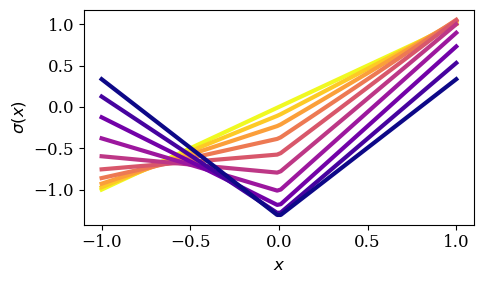

In [95]:
x = torch.from_numpy(np.linspace(-1,1,100))
plt.figure(figsize=(5,3))
for alpha in np.linspace(-1,1,10):
    plt.plot(x, get_act(alpha)(x), color=cmap((alpha+1)/2))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\sigma(x)$')
    plt.tight_layout()
    plt.savefig(savedir+'nonlinearities.pdf')
plt.show()